In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cvxpy as cp
from Unit import ChinaPowerSystem
from plot import plot_power, plot_power_q#, plot_invest, plot_primary
from Read_file import gbv
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False 
import warnings
warnings.filterwarnings('ignore')

In [10]:
multiperiods = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060]
# Provinces = gbv.Provinces
china = ChinaPowerSystem(multiperiods)


In [11]:
# 全国装机总量约束
constraints_cap = [
    cp.sum(china.PSM.CoalUnit.QCAP_new) <= 520,
    china.PSM.CoalUnit.QCAP_new[1:2] <= [330, ],
    china.PSM.NuclearUnit.QCAP <= [55, 90, 120, 160, 200, 240, 280, 285, 290],
    china.PSM.NuclearUnit.QCAP >= [48, 89.1, 118.8, 158.4, 178.2, 188.1, 198, 207.9, 217.8],
    china.PSM.PVUnit.QCAP <= [260, 1100, 2200, 2980, 3760, 4650, 5500, 6300, 6500],
    china.PSM.PVUnit.QCAP >= [245, 392.8, 526, 872, 1275, 2200, 2600, 3050, 3300],
    china.PSM.OnWindUnit.QCAP + china.PSM.OffWindUnit.QCAP <= [290, 750, 1200, 1710, 2380, 2850, 3220, 3790, 4260],
    china.PSM.OnWindUnit.QCAP + china.PSM.OffWindUnit.QCAP >= [279, 300, 403.4, 886.6, 1302.7, 1650, 1900, 2050, 2160],
    
    china.PSM.HydroUnit.QCAP[1:3] <= [450, 520],
    china.PSM.HydroUnit.QCAP >= 300,
    china.PSM.BiomassUnit.QCAP <= 60,
    china.PSM.OilUnit.QCAP <= 65,
    china.PSM.BECCSUnit.QCAP[:3] <= [0, 0, 0],
   
]
china.constraints += constraints_cap

china.constraints.extend([china.PSM.emissionELC() <= [410000, 505000, 480000, 403000, 362695, 240000, 121500, 42500, 0]])


In [12]:
obj = cp.Minimize(china.TotalCost())
prob = cp.Problem(obj, china.constraints)
prob.solve(solver=cp.SCIPY, scipy_options={"method":"highs-ds"})
# prob.solve(solver=cp.MOSEK, verbose=False)
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value 948128.3653634037


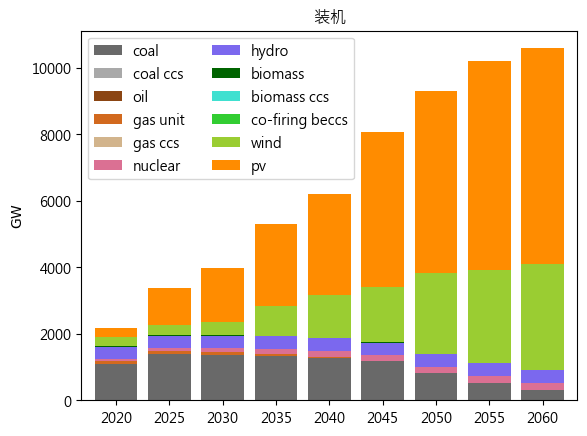

In [13]:
# 全国装机
colors = ["dimgrey", "darkgrey", "saddlebrown", "chocolate", "tan", "palevioletred", "mediumslateblue", "darkgreen", "turquoise", "limegreen", "yellowgreen", "darkorange"]
cap_china = pd.DataFrame(np.vstack([china.PSM.CoalUnit.QCAP.value, 
            china.PSM.CoalUnitCCS.QCAP.value, 
            china.PSM.OilUnit.QCAP.value, 
            china.PSM.GasUnit.QCAP.value, 
            china.PSM.GasUnitCCS.QCAP.value, 
            china.PSM.NuclearUnit.QCAP.value, 
            china.PSM.HydroUnit.QCAP.value, 
            china.PSM.BiomassUnit.QCAP.value, 
            china.PSM.BECCSUnit.QCAP.value, 
            china.PSM.CBECCSUnit_QCAP().value, 
            china.PSM.OnWindUnit.QCAP.value + china.PSM.OffWindUnit.QCAP.value, 
            china.PSM.PVUnit.QCAP.value]),
            columns=multiperiods, index=["coal","coal ccs", "oil", "gas unit","gas ccs", "nuclear", "hydro", "biomass", "biomass ccs", "co-firing beccs", "wind", "pv", ]
).T    
# cap_china.to_excel("cap_china.xlsx")
cap_china.plot.bar(title="装机",color=colors, stacked=True, ylabel="$\mathrm{GW}$", rot=0, width=0.8, edgecolor="none")
plt.legend(loc=0, ncol=2)

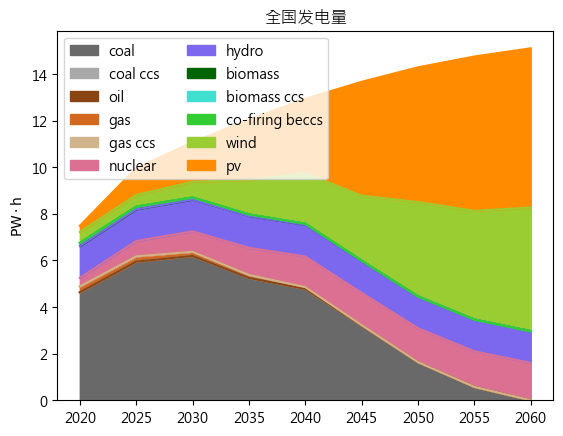

In [14]:
elec_china = pd.DataFrame(np.vstack((china.PSM.CoalUnit.QSELEC.value,
                                     china.PSM.CoalUnitCCS.QSELEC.value,
                                     china.PSM.OilUnit.QSELEC.value, 
                                     china.PSM.GasUnit.QSELEC.value,
                                     china.PSM.GasUnitCCS.QSELEC.value,
                                     china.PSM.NuclearUnit.QSELEC.value,
                                     china.PSM.HydroUnit.QSELEC.value,
                                     china.PSM.BiomassUnit.QSELEC.value,
                                     china.PSM.BECCSUnit.QSELEC.value, 
                                     china.PSM.CBECCSUnit_QSELEC().value,
                                     china.PSM.OnWindUnit.QSELEC.value + china.PSM.OffWindUnit.QSELEC.value, 
                                     china.PSM.PVUnit.QSELEC.value)) / 3600,
                    columns=multiperiods, index=["coal", "coal ccs", "oil", "gas", "gas ccs", "nuclear",
                                                "hydro", "biomass", "biomass ccs", "co-firing beccs", "wind", "pv"]).T    # 发电量

elec_china.plot.area(title="全国发电量", ylabel="$\mathrm{PW\cdot h}$", color=colors, rot=0)
plt.legend(loc=0, ncol=2)


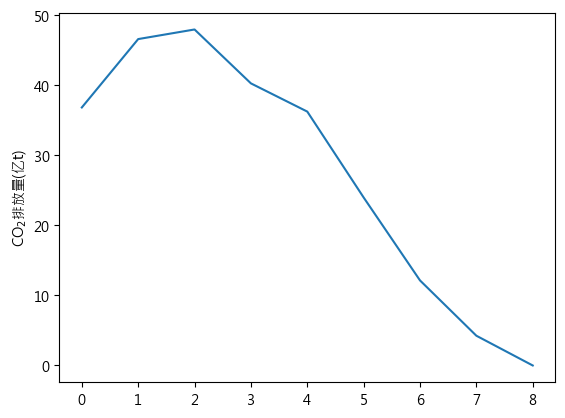

In [23]:
plt.plot(china.PSM.emissionELC().value / 1e4)
plt.ylabel("CO$_2$排放量(亿$\mathrm{t}$)");

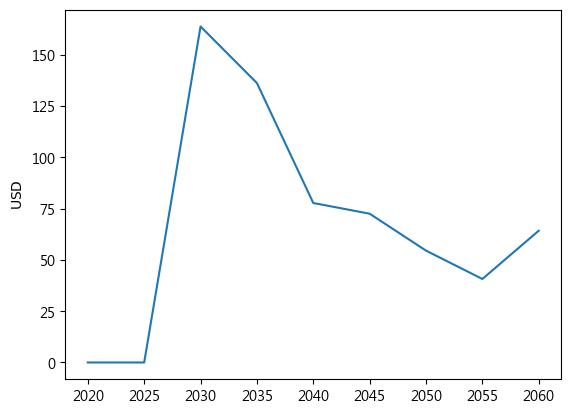

In [22]:
plt.plot(multiperiods, china.constraints[-1].dual_value * 1e6 / 1000)
plt.ylabel("$\mathrm{USD}$");